In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow import keras
from keras import callbacks, models, layers, optimizers, losses, preprocessing
import tensorflow_hub as hub
import tensorflow_text

import xgboost as xgb
import catboost as cb

# Check if GPU is available

In [2]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [3]:
df_train = pd.read_csv('../../Data/nlp-getting-started/train.csv')
df_test  = pd.read_csv('../../Data/nlp-getting-started/test.csv')

df_all = pd.concat([df_train, df_test])

print(f'df_train.shape = {df_train.shape}')
print(f'df_test.shape  = {df_test.shape}')
print(f'df_all.shape   = {df_all.shape}')

df_train.shape = (7613, 5)
df_test.shape  = (3263, 4)
df_all.shape   = (10876, 5)


In [4]:
df_train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


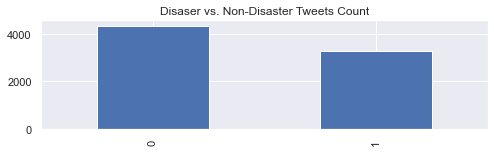

In [5]:
_ = df_train['target'].value_counts().sort_index().plot.bar(figsize=(8,2), title='Disaser vs. Non-Disaster Tweets Count')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train['keyword'].dropna().head()

31    ablaze
32    ablaze
33    ablaze
34    ablaze
35    ablaze
Name: keyword, dtype: object

In [8]:
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
df_train['location'].dropna().head()

31                       Birmingham
32    Est. September 2012 - Bristol
33                           AFRICA
34                 Philadelphia, PA
35                       London, UK
Name: location, dtype: object

In [10]:
df_train['location'].value_counts()

USA                   104
New York               71
United States          50
London                 45
Canada                 29
                     ... 
Anna Maria, FL          1
Sioux Falls, S.D.       1
Ebola                   1
Srinagar,Kashmir        1
MÌ©xico D.F.            1
Name: location, Length: 3341, dtype: int64

# Train-Test Split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train.text.values, df_train.target.values,
    stratify=df_train.target.values,
    random_state=42,
    test_size=0.1,
    shuffle=True
)

print(f'X_train.shape = {X_train.shape} | y_train.shape = {y_train.shape}')
print(f'X_val.shape   = {X_val.shape}  | y_val.shape   = {y_val.shape}')

X_train.shape = (6851,) | y_train.shape = (6851,)
X_val.shape   = (762,)  | y_val.shape   = (762,)


# Building Basic Models

### Logistic Regression on TF-IDF

In [12]:
tfv = TfidfVectorizer(
    min_df=3,
    max_features=None,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1,3),
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    stop_words='english'
)

tfv.fit(list(X_train) + list(X_val))

X_train_tfv = tfv.transform(X_train)
X_val_tfv   = tfv.transform(X_val)

print(f'X_train_tfv.shape = {X_train_tfv.shape} | y_train.shape = {y_train.shape}')
print(f'X_val_tfv.shape   = {X_val_tfv.shape}  | y_val.shape   = {y_val.shape}')

X_train_tfv.shape = (6851, 9229) | y_train.shape = (6851,)
X_val_tfv.shape   = (762, 9229)  | y_val.shape   = (762,)


In [13]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.75712
Precision = 0.83704
Recall    = 0.69113


### Logistic Regression on CountVectorizer

In [14]:
ctv = CountVectorizer(
    analyzer='word',
    token_pattern='\w{1,}',
    ngram_range=(1,3),
    stop_words='english',
)

ctv.fit(list(X_train) + list(X_val))

X_train_ctv = ctv.transform(X_train)
X_val_ctv   = ctv.transform(X_val)

print(f'X_train_ctv.shape = {X_train_ctv.shape} | y_train.shape = {y_train.shape}')
print(f'X_val_ctv.shape   = {X_val_ctv.shape}  | y_val.shape   = {y_val.shape}')

X_train_ctv.shape = (6851, 132070) | y_train.shape = (6851,)
X_val_ctv.shape   = (762, 132070)  | y_val.shape   = (762,)


In [15]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train_ctv, y_train)

predictions = clf.predict(X_val_ctv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.73737
Precision = 0.82022
Recall    = 0.66972


### Naive Bayes on TF-IDF

In [16]:
clf = MultinomialNB()
clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.72125
Precision = 0.83806
Recall    = 0.63303


### XGBoost on TF-IDF

In [17]:
clf = xgb.XGBClassifier(
    max_depth=7, 
    n_estimators=200, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=10, 
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
)

clf.fit(X_train_tfv, y_train)

predictions = clf.predict(X_val_tfv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.73058
Precision = 0.79496
Recall    = 0.67584


### XGBoost on CountVectorizer

In [18]:
clf = xgb.XGBClassifier(
    max_depth=7, 
    n_estimators=200, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    nthread=10, 
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
)

clf.fit(X_train_ctv, y_train)

predictions = clf.predict(X_val_ctv)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

F1 Score  = 0.74622
Precision = 0.82836
Recall    = 0.6789


# Deep Learning

In [19]:
tf.random.set_seed(42)

In [20]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

### Using nnlm-en-dim50/1 embedding

In [116]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [117]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=5,
    verbose=0
)

In [118]:
model.evaluate(X_val, y_val)

24/24 [==============================] - 0s 3ms/step - loss: 0.4766 - accuracy: 0.7756


[0.47655734419822693, 0.7755905389785767]

<AxesSubplot:>

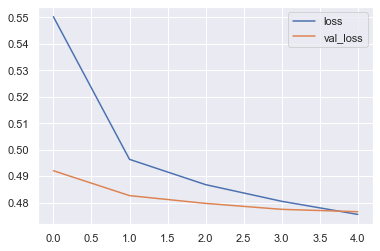

In [119]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

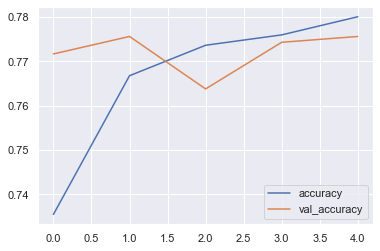

In [120]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [121]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

24/24 [==============================] - 0s 2ms/step
F1 Score  = 0.71921
Precision = 0.7766
Recall    = 0.66972


### Using universal-sentence-encoder-multilingual embedding

In [134]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3",
                   dtype=tf.string, input_shape=[], output_shape=[50]),    
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [135]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=2,
    verbose=1
)

Epoch 1/2
215/215 [==============================] - 6s 16ms/step - loss: 0.4969 - accuracy: 0.7824 - val_loss: 0.4172 - val_accuracy: 0.8110
Epoch 2/2
215/215 [==============================] - 3s 13ms/step - loss: 0.4188 - accuracy: 0.8154 - val_loss: 0.4067 - val_accuracy: 0.8360


In [136]:
model.evaluate(X_val, y_val)

24/24 [==============================] - 0s 12ms/step - loss: 0.4067 - accuracy: 0.8360


[0.4067223370075226, 0.8359580039978027]

<AxesSubplot:>

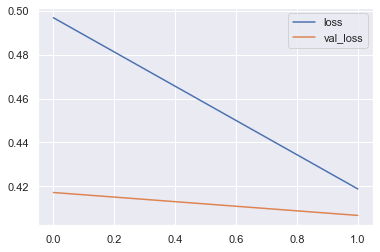

In [137]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

<AxesSubplot:>

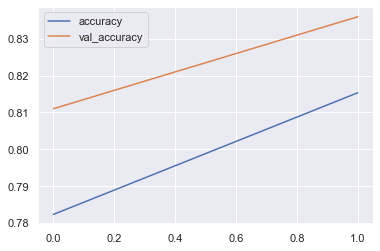

In [138]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [139]:
predictions = model.predict(X_val)

predictions = np.round(predictions)

print(f'F1 Score  = {np.round(metrics.f1_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Precision = {np.round(metrics.precision_score(y_true=y_val, y_pred=predictions),5)}')
print(f'Recall    = {np.round(metrics.recall_score(y_true=y_val, y_pred=predictions),5)}')

24/24 [==============================] - 1s 11ms/step
F1 Score  = 0.79871
Precision = 0.84354
Recall    = 0.75841


In [140]:
predictions = model.predict(df_test.text.values)
predictions = np.round(predictions).astype(int)

submission = pd.DataFrame({'id': df_test['id'], 'target': predictions.reshape(-1)})
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 14ms/step


#### Leaderboard Score

<img src="score_univ_sen_encoder.png">